In [527]:
import pandas as pd
import numpy as np
import scipy.sparse as ss

import pickle
from collections import Counter
from pprint import pprint

import re
import string

import nltk
#nltk.download()
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import spacy
from spacy import displacy
from spacy.symbols import amod
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

import scattertext as st

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pyLDAvis
import pyLDAvis.sklearn


from corextopic import corextopic as ct
from corextopic import vis_topic as vt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import swat
from sklearn.manifold import TSNE

# Get Data

In [613]:
with open('JOINT_ted_video_transcripts_comments_stats.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [618]:
df.shape

(1978, 34)

In [619]:
df = df.dropna()

In [620]:
df.head()


,video_id,transcript,polarity_neg_transcript,polarity_pos_transcript,polarity_neu_transcript,polarity_compound_transcript,tags,title,publushed_date,comments_count,...,trust,fear,negative,sadness,anger,surprise,positive,disgust,joy,anticipation
0,YgAuFqEs6yk,remember watch father raise pistol plead gu...,0.133,0.330,0.537,0.9996,"[Family, Parenting, Communication, Children, R...","How to co-parent as allies, not adversaries | ...",2020-05-14 14:40:00,109,...,0.007296,0.003192,0.003648,0.002736,0.001824,0.004560,0.019608,0.001368,0.010032,0.008664
1,bNmRr-BYnxA,think give half humanity ' spend week...,0.194,0.267,0.539,0.9980,"[climate change, environment, global issues, c...",How to shift your mindset and choose your futu...,2020-05-13 14:22:51,205,...,0.008208,0.004560,0.006840,0.002280,0.003648,0.002280,0.021888,0.002280,0.004560,0.008664
2,FVUkKKc3Vvk,work trading floor ' m pretty new graduate ...,0.111,0.306,0.583,0.9993,"[Life, Society, Immigration, Humanity, Self, P...",What's missing from the American immigrant nar...,2020-05-12 18:06:31,234,...,0.003648,0.001368,0.001824,0.001824,0.000912,0.001824,0.005928,0.000000,0.002280,0.005016
3,8bj0GR34XWc,worry pandemic pretty life play absolut...,0.135,0.166,0.699,0.9492,"[global issues, science, collaboration, virus,...",A global pandemic calls for global solutions |...,2020-05-11 15:52:37,236,...,0.004104,0.002736,0.004560,0.002736,0.002736,0.001824,0.006840,0.002280,0.002736,0.002280
4,eaCrsBtiYA4,public policy wonk investigate datum point ...,0.200,0.164,0.636,-0.9904,[],Racism has a cost for everyone | Heather C. Mc...,2020-05-08 18:44:35,542,...,0.004104,0.000912,0.001824,0.001368,0.000912,0.002280,0.008208,0.000456,0.003192,0.003192


### LDA PyViz

# Topic Modeling

In [532]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print(ix) #"\nTopic ", 
        else:
            print(topic_names[ix]) #"\nTopic: '",    #,"'"
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

### Text transformation

TF_IDF

In [533]:
vectorizer_TF_IDF = TfidfVectorizer(stop_words='english', max_df=1.0, min_df=2, strip_accents='ascii') 
doc_word_TF_IDF = vectorizer_TF_IDF.fit_transform(list(df.transcript))

In [534]:
pd.DataFrame(doc_word_TF_IDF.toarray(), columns=vectorizer_TF_IDF.get_feature_names()).shape

(1978, 19054)

In [535]:
dtm_TF_IDF = pd.DataFrame(doc_word_TF_IDF.toarray(), index=df['video_id'], columns=vectorizer_TF_IDF.get_feature_names())
words_TF_IDF = list(np.asarray(vectorizer_TF_IDF.get_feature_names()))

### NMF (Non-Negative Matrix Factorization)

In [536]:
nmf_model = NMF(10)
doc_topic = nmf_model.fit_transform(doc_word_TF_IDF)

In [537]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2", "component_3","component_4", "component_5",
                     "component_6","component_7", "component_8","component_9", "component_10"],
             columns = vectorizer_TF_IDF.get_feature_names())
topic_word

,000th,0s,1000th,100th,10th,10x,11th,12th,130th,13th,...,zoning,zoo,zoologist,zoom,zoonotic,zoop,zoos,zuccotti,zurich,zygote
component_1,0.001,0.003,0.000,0.000,0.001,0.000,0.002,0.001,0.003,0.002,...,0.000,0.000,0.001,0.033,0.000,0.000,0.000,0.000,0.004,0.000
component_2,0.000,0.000,0.000,0.005,0.003,0.000,0.003,0.003,0.001,0.006,...,0.000,0.003,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.000
component_3,0.000,0.000,0.000,0.003,0.000,0.001,0.002,0.003,0.000,0.001,...,0.000,0.000,0.000,0.000,0.003,0.000,0.000,0.003,0.001,0.000
component_4,0.004,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.010,0.000,0.002,0.005,0.000,0.000,0.000,0.001,0.000
component_5,0.000,0.000,0.002,0.001,0.000,0.001,0.000,0.000,0.000,0.000,...,0.000,0.012,0.000,0.025,0.000,0.000,0.001,0.000,0.001,0.000
component_6,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,...,0.000,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_7,0.000,0.000,0.000,0.001,0.002,0.000,0.003,0.001,0.000,0.000,...,0.015,0.000,0.000,0.003,0.000,0.000,0.000,0.001,0.001,0.003
component_8,0.000,0.000,0.000,0.000,0.003,0.000,0.000,0.001,0.000,0.000,...,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_9,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.002,0.000,0.013,0.000,0.000,0.001,0.000,0.001,0.000
component_10,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000


In [538]:
display_topics(model = nmf_model, feature_names = vectorizer_TF_IDF.get_feature_names(), 
               no_top_words=10, topic_names=["Technology",
                                        "Phylosophy of Life",
                                        "International Politics",
                                        "Healthcare",
                                        "Planet Sustainability",
                                        "Gender",
                                        "Urbanistics", 
                                        "Education", 
                                        "Neuroscience",
                                        "Automation"])

Technology
computer datum technology machine information work thing video image design
Phylosophy of Life
say life love time story feel year thing write friend
International Politics
country government company business need percent economy global economic money
Healthcare
patient cancer cell drug health disease doctor care medical hospital
Planet Sustainability
planet water earth ocean climate carbon mars plant solar fish
Gender
woman man girl sex gender female male sexual violence boy
Urbanistics
city building design community build space architecture street neighborhood urban
Education
school child kid student teacher girl education parent family college
Neuroscience
brain neuron sleep cell disease emotion behavior body study memory
Automation
robot ai human robotic machine intelligence technology job artificial task


In [539]:
doc_topic_nmf = pd.DataFrame(doc_topic.round(5),
                             index=df['video_id'],
                             columns = ["Technology",
                                        "Philosophy of Life",
                                        "Global Economy",
                                        "Healthcare",
                                        "Planet Sustainability",
                                        "Gender",
                                        "Urbanistics", 
                                        "Education", 
                                        "Neuroscience",
                                        "Automation"])
doc_topic_nmf

,Technology,Philosophy of Life,Global Economy,Healthcare,Planet Sustainability,Gender,Urbanistics,Education,Neuroscience,Automation
video_id,,,,,,,,,,
YgAuFqEs6yk,0.00000,0.13317,0.00000,0.00000,0.00340,0.00000,0.00000,0.05191,0.00000,0.00000
bNmRr-BYnxA,0.00000,0.07844,0.07128,0.00350,0.03268,0.00000,0.00970,0.00000,0.00820,0.00394
FVUkKKc3Vvk,0.00000,0.08487,0.02691,0.00000,0.00477,0.00000,0.00157,0.08795,0.00000,0.00239
8bj0GR34XWc,0.02037,0.01940,0.03858,0.08271,0.00181,0.00000,0.00000,0.00000,0.00406,0.00000
eaCrsBtiYA4,0.00000,0.03334,0.10372,0.00559,0.00000,0.01508,0.02818,0.03159,0.00000,0.00215
...,...,...,...,...,...,...,...,...,...,...
ooUqOwh-2LE,0.03912,0.06816,0.00000,0.00000,0.00000,0.00524,0.05592,0.02201,0.00000,0.00000
SFW0TEFKCxk,0.03464,0.00000,0.00000,0.06076,0.06560,0.00000,0.01167,0.00134,0.00189,0.00023
yqc9zX04DXs,0.04618,0.01113,0.00844,0.00000,0.13052,0.00000,0.00000,0.00402,0.01926,0.00001


In [540]:
doc_topic_nmf['Topic'] = doc_topic_nmf.idxmax(axis=1)

In [541]:
doc_topic_nmf


,Technology,Philosophy of Life,Global Economy,Healthcare,Planet Sustainability,Gender,Urbanistics,Education,Neuroscience,Automation,Topic
video_id,,,,,,,,,,,
YgAuFqEs6yk,0.00000,0.13317,0.00000,0.00000,0.00340,0.00000,0.00000,0.05191,0.00000,0.00000,Philosophy of Life
bNmRr-BYnxA,0.00000,0.07844,0.07128,0.00350,0.03268,0.00000,0.00970,0.00000,0.00820,0.00394,Philosophy of Life
FVUkKKc3Vvk,0.00000,0.08487,0.02691,0.00000,0.00477,0.00000,0.00157,0.08795,0.00000,0.00239,Education
8bj0GR34XWc,0.02037,0.01940,0.03858,0.08271,0.00181,0.00000,0.00000,0.00000,0.00406,0.00000,Healthcare
eaCrsBtiYA4,0.00000,0.03334,0.10372,0.00559,0.00000,0.01508,0.02818,0.03159,0.00000,0.00215,Global Economy
...,...,...,...,...,...,...,...,...,...,...,...
ooUqOwh-2LE,0.03912,0.06816,0.00000,0.00000,0.00000,0.00524,0.05592,0.02201,0.00000,0.00000,Philosophy of Life
SFW0TEFKCxk,0.03464,0.00000,0.00000,0.06076,0.06560,0.00000,0.01167,0.00134,0.00189,0.00023,Planet Sustainability
yqc9zX04DXs,0.04618,0.01113,0.00844,0.00000,0.13052,0.00000,0.00000,0.00402,0.01926,0.00001,Planet Sustainability


In [542]:
cosine_similarity((doc_topic_nmf.iloc[:, :10].values[0], 
                   doc_topic_nmf.iloc[:, :10].values[1], 
                   doc_topic_nmf.iloc[:, :10].values[3],  
                   doc_topic_nmf.iloc[:, :10].values[4], 
                   doc_topic_nmf.iloc[:, :10].values[5], 
                   doc_topic_nmf.iloc[:, :10].values[6]))

array([[1.        , 0.66069262, 0.18945807, 0.36036741, 0.16945787,
        0.00629454],
       [0.66069262, 1.        , 0.43552788, 0.78173567, 0.12178554,
        0.12933045],
       [0.18945807, 0.43552788, 1.        , 0.45300301, 0.34394332,
        0.81850333],
       [0.36036741, 0.78173567, 0.45300301, 1.        , 0.08134745,
        0.04777144],
       [0.16945787, 0.12178554, 0.34394332, 0.08134745, 1.        ,
        0.56298335],
       [0.00629454, 0.12933045, 0.81850333, 0.04777144, 0.56298335,
        1.        ]])

In [543]:
pairwise_distances(doc_topic[0].reshape(1, -1),doc_topic,metric='cosine').argsort()

array([[   0,  295, 1416, ..., 1240,  193, 1901]])

In [544]:
df.head()

,video_id,transcript,polarity_neg_transcript,polarity_pos_transcript,polarity_neu_transcript,polarity_compound_transcript,tags,title,publushed_date,comments_count,...,trust,fear,negative,sadness,anger,surprise,positive,disgust,joy,anticipation
0,YgAuFqEs6yk,remember watch father raise pistol plead gu...,0.133,0.330,0.537,0.9996,"[Family, Parenting, Communication, Children, R...","How to co-parent as allies, not adversaries | ...",2020-05-14 14:40:00,109,...,0.007296,0.003192,0.003648,0.002736,0.001824,0.004560,0.019608,0.001368,0.010032,0.008664
1,bNmRr-BYnxA,think give half humanity ' spend week...,0.194,0.267,0.539,0.9980,"[climate change, environment, global issues, c...",How to shift your mindset and choose your futu...,2020-05-13 14:22:51,205,...,0.008208,0.004560,0.006840,0.002280,0.003648,0.002280,0.021888,0.002280,0.004560,0.008664
2,FVUkKKc3Vvk,work trading floor ' m pretty new graduate ...,0.111,0.306,0.583,0.9993,"[Life, Society, Immigration, Humanity, Self, P...",What's missing from the American immigrant nar...,2020-05-12 18:06:31,234,...,0.003648,0.001368,0.001824,0.001824,0.000912,0.001824,0.005928,0.000000,0.002280,0.005016
3,8bj0GR34XWc,worry pandemic pretty life play absolut...,0.135,0.166,0.699,0.9492,"[global issues, science, collaboration, virus,...",A global pandemic calls for global solutions |...,2020-05-11 15:52:37,236,...,0.004104,0.002736,0.004560,0.002736,0.002736,0.001824,0.006840,0.002280,0.002736,0.002280
4,eaCrsBtiYA4,public policy wonk investigate datum point ...,0.200,0.164,0.636,-0.9904,[],Racism has a cost for everyone | Heather C. Mc...,2020-05-08 18:44:35,542,...,0.004104,0.000912,0.001824,0.001368,0.000912,0.002280,0.008208,0.000456,0.003192,0.003192


In [545]:
tsne = TSNE(metric='cosine')

In [546]:
tsne_features = tsne.fit_transform(doc_topic_nmf.iloc[:, :10])

In [547]:
#doc_topic_nmf['prime_topic']

In [548]:
xs = tsne_features[:, 0]
ys = tsne_features[:, 1]
#marker=df.emotion

In [549]:
#df.fear*1000

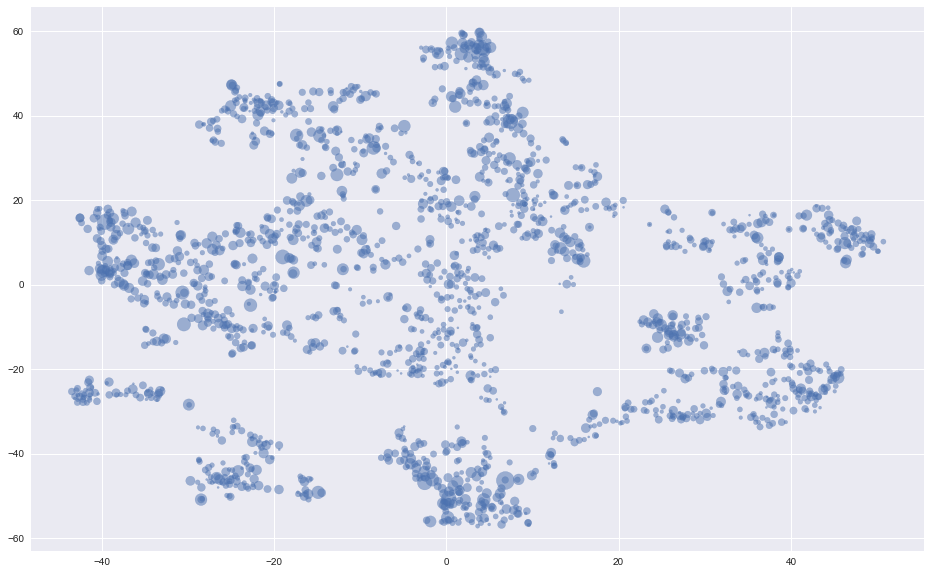

In [550]:
plt.figure(figsize=(16,10))
plt.scatter(xs, ys,alpha=0.5, s = df.anticipation*10000);

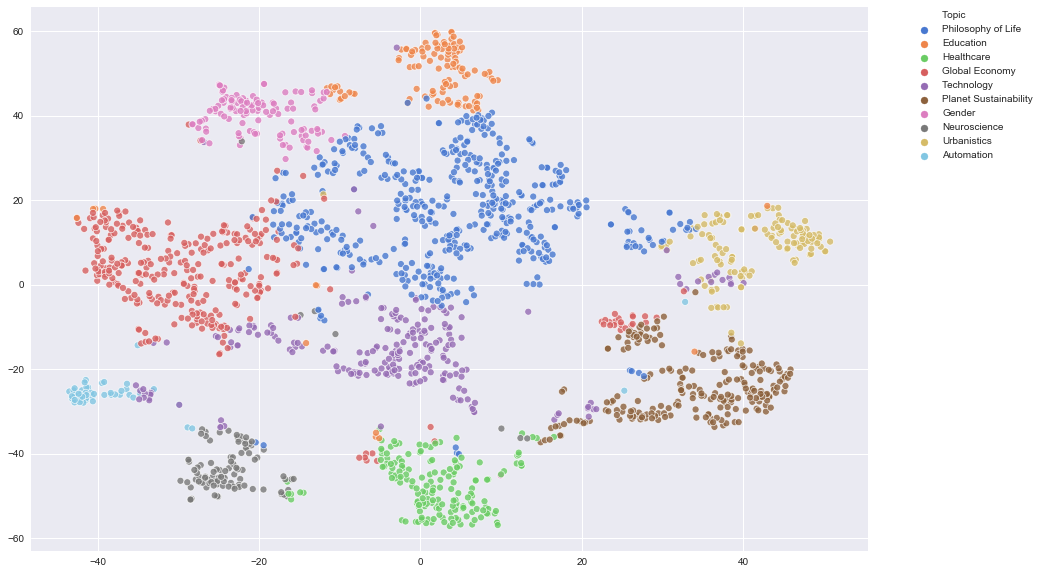

In [552]:
plt.figure(figsize=(15,10))
g = sns.scatterplot(
    x=xs, y=ys,
    hue='Topic',
    palette=sns.color_palette("muted", 10),
    data=doc_topic_nmf,
    legend='full',
    alpha=0.8)

# title
#new_title = 'My title'
#g.legend.set_title(new_title)

#legend = g._legend
#plt.legend(doc_topic_nmf['Topic'].unique(), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("TSNE_Topics.svg", bbox_inches='tight');

In [553]:
doc_topic_nmf['Topic'].unique()

array(['Philosophy of Life', 'Education', 'Healthcare', 'Global Economy',
       'Technology', 'Planet Sustainability', 'Gender', 'Neuroscience',
       'Urbanistics', 'Automation'], dtype=object)

# Adding emotions

In [557]:
doc_topic_nmf_rich = pd.merge(doc_topic_nmf, df,  how='left', left_on='video_id', right_on = 'video_id')

In [559]:
doc_topic_nmf_rich['prime_emotion'] = doc_topic_nmf_rich.loc[:,['trust', 'fear', 'sadness', 'anger', 
                                                                'surprise', 'disgust', 'joy', 
                                                                'anticipation']].idxmax(axis=1)

In [560]:
doc_topic_nmf_rich['polarity_vader'] = doc_topic_nmf_rich.loc[:,['polarity_neg_comments', 
                                                                 'polarity_pos_comments']].idxmax(axis=1)

In [561]:
doc_topic_nmf_rich['polarity_plutchik'] = doc_topic_nmf_rich.loc[:,['negative', 
                                                                 'positive']].idxmax(axis=1)

In [562]:
doc_topic_nmf_rich.shape

(1982, 48)

In [564]:
doc_topic_nmf_rich.head()

,video_id,Technology,Philosophy of Life,Global Economy,Healthcare,Planet Sustainability,Gender,Urbanistics,Education,Neuroscience,...,sadness,anger,surprise,positive,disgust,joy,anticipation,prime_emotion,polarity_vader,polarity_plutchik
0,YgAuFqEs6yk,0.00000,0.13317,0.00000,0.00000,0.00340,0.00000,0.00000,0.05191,0.00000,...,0.002736,0.001824,0.004560,0.019608,0.001368,0.010032,0.008664,joy,polarity_pos_comments,positive
1,bNmRr-BYnxA,0.00000,0.07844,0.07128,0.00350,0.03268,0.00000,0.00970,0.00000,0.00820,...,0.002280,0.003648,0.002280,0.021888,0.002280,0.004560,0.008664,anticipation,polarity_pos_comments,positive
2,FVUkKKc3Vvk,0.00000,0.08487,0.02691,0.00000,0.00477,0.00000,0.00157,0.08795,0.00000,...,0.001824,0.000912,0.001824,0.005928,0.000000,0.002280,0.005016,anticipation,polarity_pos_comments,positive
3,8bj0GR34XWc,0.02037,0.01940,0.03858,0.08271,0.00181,0.00000,0.00000,0.00000,0.00406,...,0.002736,0.002736,0.001824,0.006840,0.002280,0.002736,0.002280,trust,polarity_neg_comments,positive
4,eaCrsBtiYA4,0.00000,0.03334,0.10372,0.00559,0.00000,0.01508,0.02818,0.03159,0.00000,...,0.001368,0.000912,0.002280,0.008208,0.000456,0.003192,0.003192,trust,polarity_pos_comments,positive


In [565]:
doc_topic_nmf_rich_tech = doc_topic_nmf_rich[doc_topic_nmf_rich['Topic'] == 'Technology']

In [566]:
#doc_topic_nmf_rich_tech.info()

In [568]:
doc_topic_nmf_rich_phi = doc_topic_nmf_rich[doc_topic_nmf_rich['Topic'] == 'Phylosophy of Life']

In [569]:
fontsize=18

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


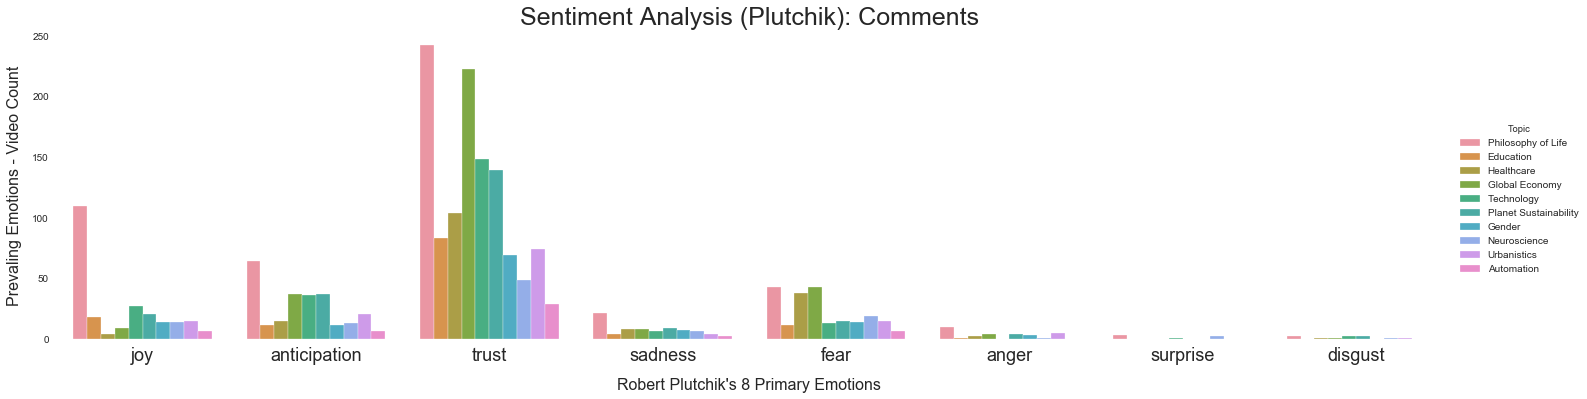

In [570]:
with sns.axes_style('white'):
    g = sns.factorplot("prime_emotion", data=doc_topic_nmf_rich, aspect=4.0, kind='count',
                       hue='Topic')
    axes = g.axes.flatten()
    axes[0].set_title('Sentiment Analysis (Plutchik): Comments', fontsize=25)
    g.set_ylabels('Prevaling Emotions - Video Count', fontsize=16, labelpad=10)
    g.set_xlabels("Robert Plutchik's 8 Primary Emotions", fontsize=16, labelpad=13)
    g.set_xticklabels(size=18)
plt.savefig("Plutchik.svg", bbox_inches='tight');

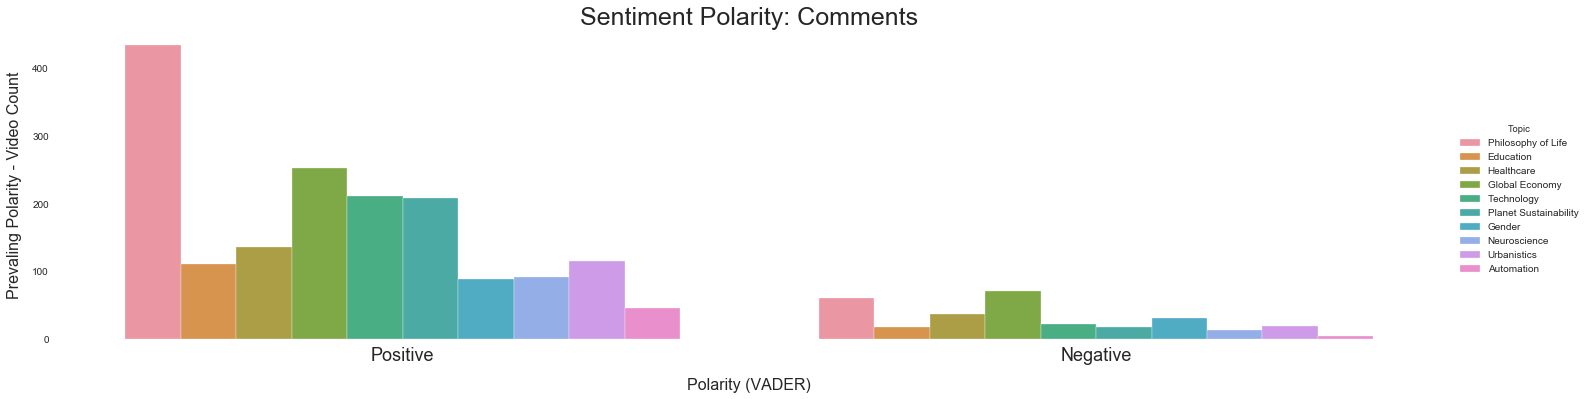

In [571]:
with sns.axes_style('white'):
    g = sns.factorplot("polarity_vader", data=doc_topic_nmf_rich, aspect=4.0, kind='count',
                       hue='Topic')
    axes = g.axes.flatten()
    axes[0].set_title('Sentiment Polarity: Comments', fontsize=25)
    g.set_ylabels('Prevaling Polarity - Video Count', fontsize=16, labelpad=10)
    g.set_xlabels("Polarity (VADER)", fontsize=16, labelpad=13)
    g.set_xticklabels(['Positive', 'Negative'], size=18)
plt.savefig("Vader.svg", bbox_inches='tight');

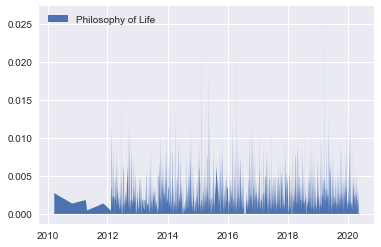

In [572]:
plt.stackplot(doc_topic_nmf_rich['publushed_date'],
              doc_topic_nmf_rich['anger'], 
              labels=doc_topic_nmf_rich['Topic'])
plt.legend(loc='upper left')
plt.show()

In [574]:
doc_topic_nmf_rich.columns

Index(['video_id', 'Technology', 'Philosophy of Life', 'Global Economy',
       'Healthcare', 'Planet Sustainability', 'Gender', 'Urbanistics',
       'Education', 'Neuroscience', 'Automation', 'Topic', 'transcript',
       'polarity_neg_transcript', 'polarity_pos_transcript',
       'polarity_neu_transcript', 'polarity_compound_transcript', 'tags',
       'title', 'publushed_date', 'comments_count', 'dislike_count',
       'like_count', 'views_count', 'today', 'days_age', 'views_per_day',
       'dislike_perc_of_likes', 'success', 'prime_tag', 'comments',
       'polarity_neg_comments', 'polarity_pos_comments',
       'polarity_neu_comments', 'polarity_compound_comments', 'trust', 'fear',
       'negative', 'sadness', 'anger', 'surprise', 'positive', 'disgust',
       'joy', 'anticipation', 'prime_emotion', 'polarity_vader',
       'polarity_plutchik'],
      dtype='object')

In [575]:
df_to_plot = doc_topic_nmf_rich[doc_topic_nmf_rich['Topic'] == 'Gender']

df_to_plot = df_to_plot[['publushed_date', 'trust', 'fear', 'sadness', 'anger', 'surprise', 'disgust', 'joy', 'anticipation']]


<Figure size 1872x864 with 0 Axes>

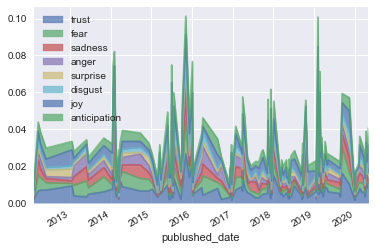

In [576]:
plt.figure(figsize=(26,12))
#plt.style.use('seaborn');

df_to_plot.plot(x = 'publushed_date', kind='area', alpha=0.7);

In [ ]:
#df_to_plot = doc_topic_nmf_rich[doc_topic_nmf_rich['Topic'] == 'Automation']

df_to_plot = df_to_plot[['publushed_date', 'trust', 'Topic']]


In [691]:
df_to_plot = doc_topic_nmf_rich.publushed_date[doc_topic_nmf_rich.Topic =='Philosophy of Life']
df_to_plot

0      2020-05-14 14:40:00
1      2020-05-13 14:22:51
8      2020-05-04 15:48:43
16     2020-04-23 16:07:54
28     2020-04-17 19:53:18
               ...        
1967   2012-03-14 16:29:08
1968   2012-03-05 20:14:36
1970   2012-02-21 18:26:30
1971   2012-02-20 17:15:40
1977   2011-11-11 16:50:21
Name: publushed_date, Length: 494, dtype: datetime64[ns]

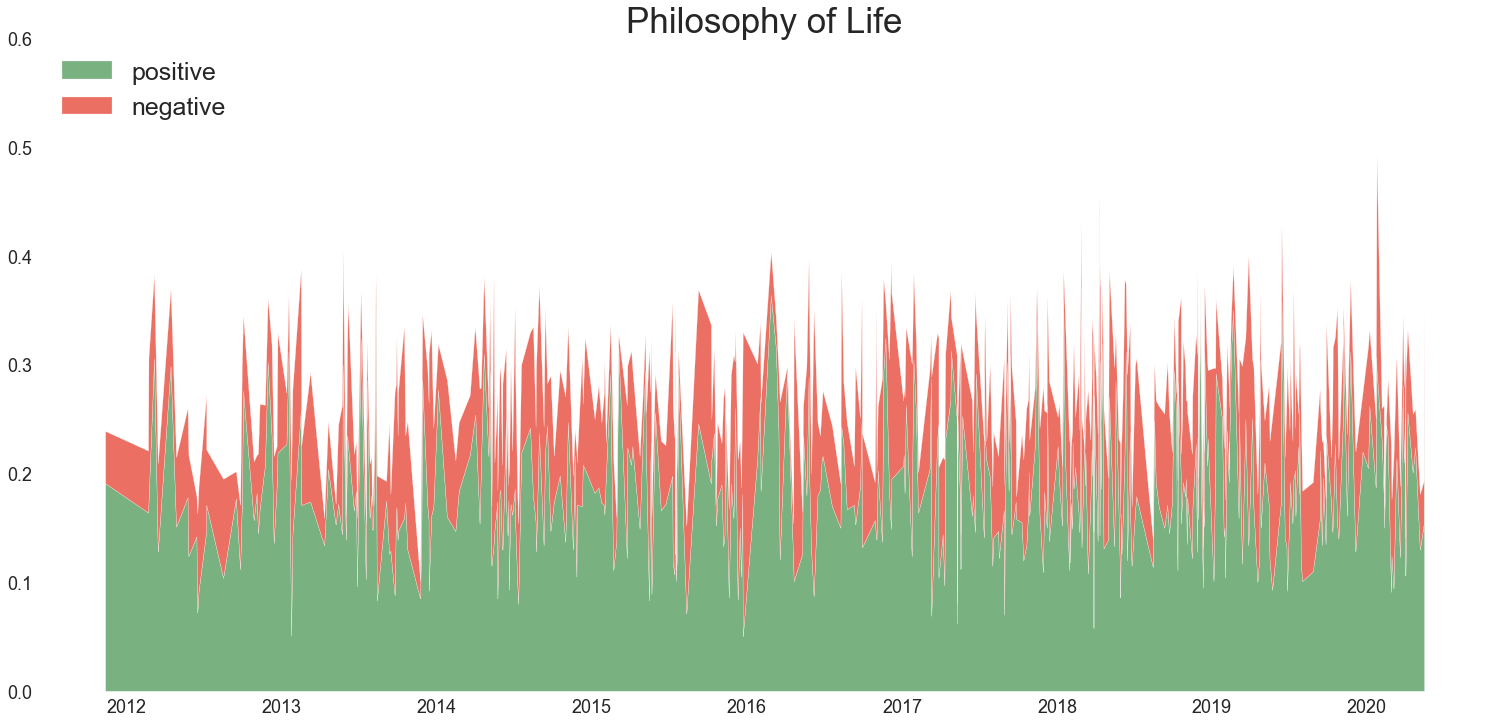

In [692]:
with sns.axes_style('white'):   
    plt.figure(figsize=(26,12));

    color_map = ["#599E61", "#e74c3c"]
    plt.stackplot(df_to_plot, doc_topic_nmf_rich.polarity_pos_comments[doc_topic_nmf_rich.Topic == 'Philosophy of Life'],
                 doc_topic_nmf_rich.polarity_neg_comments[doc_topic_nmf_rich.Topic == 'Philosophy of Life'], alpha=0.8, colors = color_map);
    plt.legend(['positive', 'negative'], fontsize=25, loc='upper left')
    plt.title('Philosophy of Life', fontsize=35)
    plt.xticks(size=18)
    plt.yticks(size=18)
    plt.ylim(0,0.6);



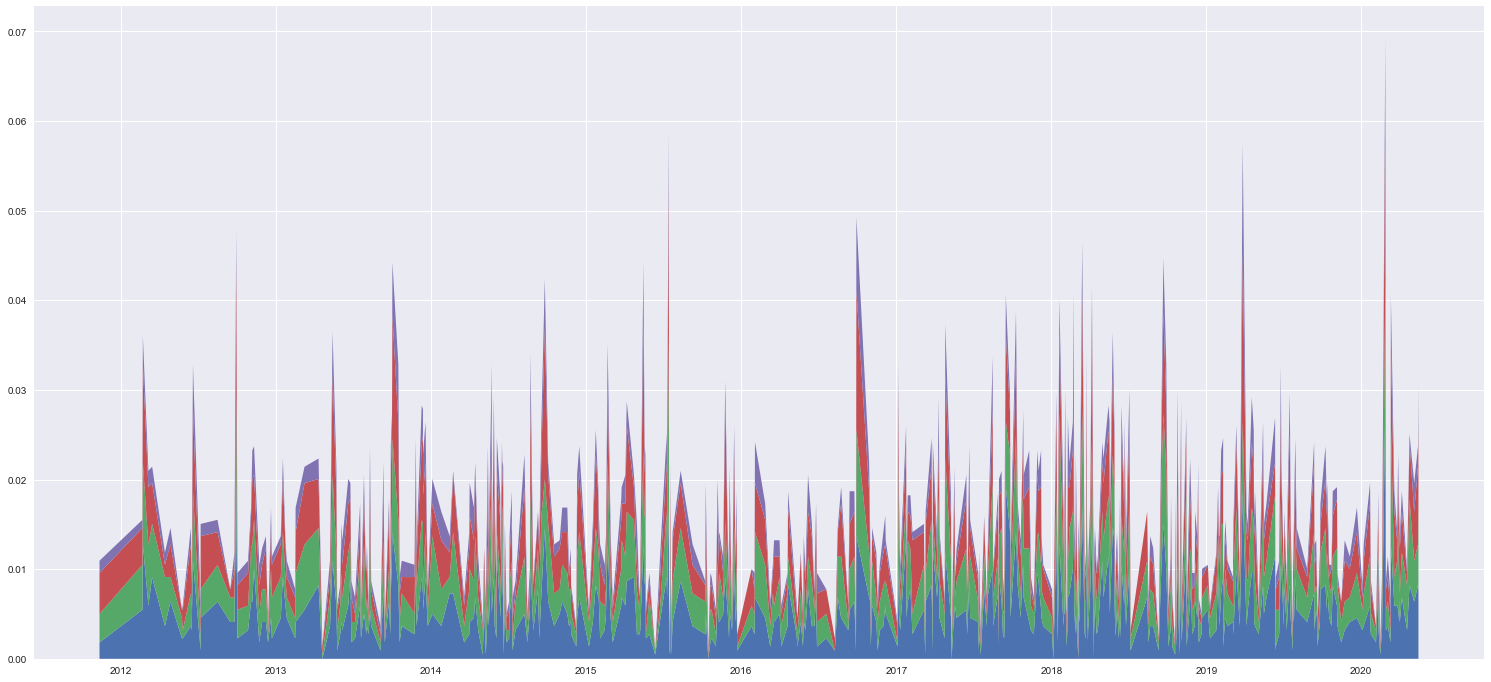

In [580]:
plt.figure(figsize=(26,12));
plt.stackplot(df_to_plot, doc_topic_nmf_rich.trust[doc_topic_nmf_rich.Topic == 'Philosophy of Life'],
             doc_topic_nmf_rich.joy[doc_topic_nmf_rich.Topic == 'Philosophy of Life'], 
             doc_topic_nmf_rich.anticipation[doc_topic_nmf_rich.Topic == 'Philosophy of Life'],
              doc_topic_nmf_rich.surprise[doc_topic_nmf_rich.Topic == 'Philosophy of Life']);



In [694]:
doc_topic_nmf_rich.columns

Index(['video_id', 'Technology', 'Philosophy of Life', 'Global Economy',
       'Healthcare', 'Planet Sustainability', 'Gender', 'Urbanistics',
       'Education', 'Neuroscience', 'Automation', 'Topic', 'transcript',
       'polarity_neg_transcript', 'polarity_pos_transcript',
       'polarity_neu_transcript', 'polarity_compound_transcript', 'tags',
       'title', 'publushed_date', 'comments_count', 'dislike_count',
       'like_count', 'views_count', 'today', 'days_age', 'views_per_day',
       'dislike_perc_of_likes', 'success', 'prime_tag', 'comments',
       'polarity_neg_comments', 'polarity_pos_comments',
       'polarity_neu_comments', 'polarity_compound_comments', 'trust', 'fear',
       'negative', 'sadness', 'anger', 'surprise', 'positive', 'disgust',
       'joy', 'anticipation', 'prime_emotion', 'polarity_vader',
       'polarity_plutchik'],
      dtype='object')

In [696]:
doc_topic_nmf_rich[doc_topic_nmf_rich['prime_emotion'] == 'disgust'].loc[:,['video_id', 'title', 'publushed_date', 'comments_count', 'dislike_count',
       'like_count', 'views_count','polarity_neg_comments', 'disgust', 'polarity_pos_comments', 'polarity_vader', 'prime_emotion']]

,video_id,title,publushed_date,comments_count,dislike_count,like_count,views_count,polarity_neg_comments,disgust,polarity_pos_comments,polarity_vader,prime_emotion
311,m19jit19v9w,Sloths! The strange life of the world's slowes...,2019-06-18 12:29:05,202,76,4239,92057,0.051,0.001824,0.129,polarity_pos_comments,disgust
372,zjrFw3MASGc,An architect's subversive reimagining of the U...,2019-03-25 14:43:42,356,348,1316,38072,0.177,0.005016,0.116,polarity_neg_comments,disgust
453,Y_p8qwDHtfA,Where do your online returns go? | Aparna Mehta,2018-12-13 16:37:59,276,228,1570,71968,0.099,0.005016,0.085,polarity_neg_comments,disgust
554,roXTB6pQn28,"""Interpassion"" / ""Ba$$in"" | Yelle",2018-09-10 15:22:46,277,541,854,43108,0.105,0.001824,0.150,polarity_pos_comments,disgust
558,i_wtaoHCw3k,What a scrapyard in Ghana can teach us about i...,2018-08-30 14:55:19,123,59,1701,59808,0.064,0.004104,0.177,polarity_pos_comments,disgust
915,bJkv9b9o9lo,"You smell with your body, not just your nose |...",2017-08-09 15:07:23,149,111,1819,132348,0.035,0.002736,0.097,polarity_pos_comments,disgust
1130,2Brajdazp1o,The taboo secret to better health | Molly Winter,2016-09-02 19:09:13,410,353,3929,314663,0.063,0.005472,0.152,polarity_pos_comments,disgust
1697,CpkXmtJOH84,Geraldine Hamilton: Body parts on a chip,2013-12-03 16:18:09,340,120,4542,244913,0.047,0.002280,0.097,polarity_pos_comments,disgust
1716,_x1qkuvUxuI,An Ode to Envy | Parul Sehgal | TED Talks,2013-10-23 15:43:23,178,131,2646,163039,0.118,0.005016,0.130,polarity_pos_comments,disgust
1796,IessjPY9gwI,Sergey Brin: Why Google Glass?,2013-05-17 17:11:51,738,1275,2431,250315,0.130,0.001824,0.141,polarity_pos_comments,disgust


In [ ]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
plt.stackplot(df_to_plot, doc_topic_nmf_rich.sadness[doc_topic_nmf_rich.Topic == 'Philosophy of Life'],
             doc_topic_nmf_rich.anger[doc_topic_nmf_rich.Topic == 'Philosophy of Life'], 
             doc_topic_nmf_rich.disgust[doc_topic_nmf_rich.Topic == 'Philosophy of Life'],
              doc_topic_nmf_rich.fear[doc_topic_nmf_rich.Topic == 'Philosophy of Life']);
plt.legend(['sadness', 'anger', 'disgust', 'fear']);


plt.stackplot(df_to_plot, doc_topic_nmf_rich.sadness[doc_topic_nmf_rich.Topic == 'Philosophy of Life'],
             doc_topic_nmf_rich.anger[doc_topic_nmf_rich.Topic == 'Philosophy of Life'], 
             doc_topic_nmf_rich.disgust[doc_topic_nmf_rich.Topic == 'Philosophy of Life'],
              doc_topic_nmf_rich.fear[doc_topic_nmf_rich.Topic == 'Philosophy of Life']);

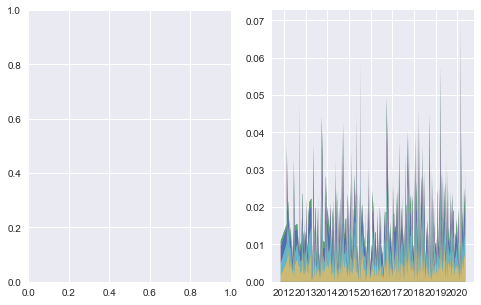

In [451]:
fig, ax = plt.subplots(1,2, sharex = False, sharey=False, figsize=[8,5])

ax[0]= plt.stackplot(df_to_plot, doc_topic_nmf_rich.trust[doc_topic_nmf_rich.Topic == 'Philosophy of Life'],
             doc_topic_nmf_rich.joy[doc_topic_nmf_rich.Topic == 'Philosophy of Life'], 
             doc_topic_nmf_rich.anticipation[doc_topic_nmf_rich.Topic == 'Philosophy of Life'],
              doc_topic_nmf_rich.surprise[doc_topic_nmf_rich.Topic == 'Philosophy of Life']);


ax[1]= plt.stackplot(df_to_plot, doc_topic_nmf_rich.trust[doc_topic_nmf_rich.Topic == 'Philosophy of Life'],
             doc_topic_nmf_rich.joy[doc_topic_nmf_rich.Topic == 'Philosophy of Life'], 
             doc_topic_nmf_rich.anticipation[doc_topic_nmf_rich.Topic == 'Philosophy of Life'],
              doc_topic_nmf_rich.surprise[doc_topic_nmf_rich.Topic == 'Philosophy of Life']);

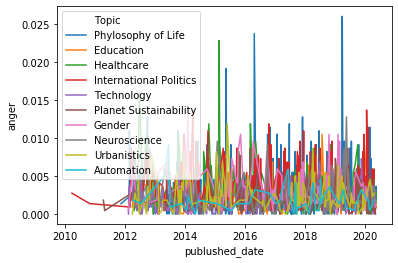

In [237]:
sns.lineplot(doc_topic_nmf_rich['publushed_date'], doc_topic_nmf_rich['anger'], hue=doc_topic_nmf_rich['Topic']);

In [242]:
#doc_topic_nmf_rich.info()

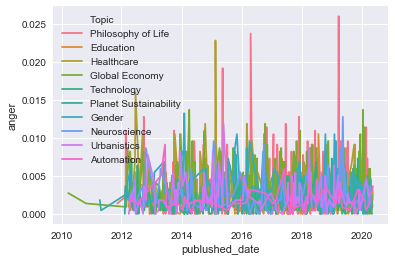

In [583]:
sns.lineplot(doc_topic_nmf_rich['publushed_date'], doc_topic_nmf_rich['anger'], hue=doc_topic_nmf_rich['Topic']);

In [584]:
doc_topic_nmf_rich

,video_id,Technology,Philosophy of Life,Global Economy,Healthcare,Planet Sustainability,Gender,Urbanistics,Education,Neuroscience,...,sadness,anger,surprise,positive,disgust,joy,anticipation,prime_emotion,polarity_vader,polarity_plutchik
0,YgAuFqEs6yk,0.00000,0.13317,0.00000,0.00000,0.00340,0.00000,0.00000,0.05191,0.00000,...,0.002736,0.001824,0.004560,0.019608,0.001368,0.010032,0.008664,joy,polarity_pos_comments,positive
1,bNmRr-BYnxA,0.00000,0.07844,0.07128,0.00350,0.03268,0.00000,0.00970,0.00000,0.00820,...,0.002280,0.003648,0.002280,0.021888,0.002280,0.004560,0.008664,anticipation,polarity_pos_comments,positive
2,FVUkKKc3Vvk,0.00000,0.08487,0.02691,0.00000,0.00477,0.00000,0.00157,0.08795,0.00000,...,0.001824,0.000912,0.001824,0.005928,0.000000,0.002280,0.005016,anticipation,polarity_pos_comments,positive
3,8bj0GR34XWc,0.02037,0.01940,0.03858,0.08271,0.00181,0.00000,0.00000,0.00000,0.00406,...,0.002736,0.002736,0.001824,0.006840,0.002280,0.002736,0.002280,trust,polarity_neg_comments,positive
4,eaCrsBtiYA4,0.00000,0.03334,0.10372,0.00559,0.00000,0.01508,0.02818,0.03159,0.00000,...,0.001368,0.000912,0.002280,0.008208,0.000456,0.003192,0.003192,trust,polarity_pos_comments,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1977,ooUqOwh-2LE,0.03912,0.06816,0.00000,0.00000,0.00000,0.00524,0.05592,0.02201,0.00000,...,0.002280,0.001368,0.001368,0.005016,0.001368,0.003192,0.004560,anticipation,polarity_pos_comments,positive
1978,SFW0TEFKCxk,0.03464,0.00000,0.00000,0.06076,0.06560,0.00000,0.01167,0.00134,0.00189,...,0.000456,0.000456,0.001368,0.006384,0.000456,0.000912,0.001368,trust,polarity_pos_comments,positive
1979,yqc9zX04DXs,0.04618,0.01113,0.00844,0.00000,0.13052,0.00000,0.00000,0.00402,0.01926,...,0.002280,0.001824,0.001368,0.010488,0.001368,0.004104,0.003192,trust,polarity_pos_comments,positive
1980,796LfXwzIUk,0.00000,0.01372,0.14443,0.00000,0.00332,0.00000,0.01000,0.00000,0.00052,...,0.001368,0.001368,0.000912,0.005016,0.000456,0.001824,0.003648,anticipation,polarity_pos_comments,positive


In [697]:
# fig, ax = plt.subplots(2,1, sharex = True, sharey=False, figsize=[8,5])
# plt.suptitle('Predicting Hostility Level MIDs: Accuracy',fontsize=20, x=0.1, y=1.05)

# #Col1
# ax[0].bar(doc_topic_nmf_rich_anger['Topic'], height=doc_topic_nmf_rich_anger['Train Accuracy'], color='gray')
# ax[0].barh(reduced_time_acc['index'], width=reduced_time_acc['Test Accuracy'], color='#66AEED')
# ax[0].axvline(x=0.65, color = 'black', ls='--')
#  ax[0].set_title('Time-Based Split', loc='left',  fontsize=15);

# #Col2
# ax[1].barh(reduced_random_acc['index'], width=reduced_random_acc['Train Accuracy'], color='gray')
# ax[1].barh(reduced_random_acc['index'], width=reduced_random_acc['Test Accuracy'], color='#66AEED')
# ax[1].legend(np.arange(2), labels=('Train', 'Test'), bbox_to_anchor=(1.03, 1.2))
# ax[1].axvline(x=0.88, color = 'black', ls='--')
# ax[1].set_title('Random Split', loc='left',  fontsize=15);

In [36]:
tsne_2 = TSNE(metric='cosine')

In [37]:
tsne_features_2 =doc_topic_nmf_rich tsne_2.fit_transform(doc_topic_nmf_rich.iloc[:, 1:11])

In [38]:
xs_2 = tsne_features_2[:, 0]
ys_2 = tsne_features_2[:, 1]

In [39]:
ys_2.shape

(1982,)

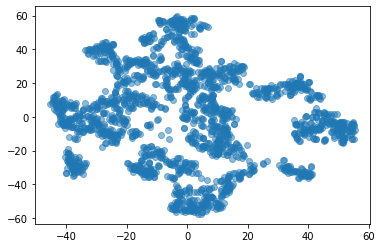

In [40]:
plt.scatter(xs_2, ys_2,
            alpha=0.5);


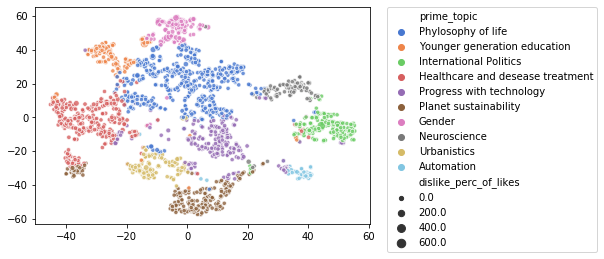

In [43]:
#plt.figure(figsize=(7,7))
sns.scatterplot(
    x=xs_2, y=ys_2,
    hue='prime_topic',
    palette=sns.color_palette("muted", 10),
    data=doc_topic_nmf_rich,
    #legend="full",
    #markers='polarity_plutchik',
    size='dislike_perc_of_likes',
    alpha=0.8
    #joint_kws={"color":colors, "marker":markers}
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [ ]:
#size = 100 * (iris.petal_length / iris.petal_length.max())
#g = sns.PairGrid(iris, vars=["sepal_length", "sepal_width"], size=5)
#g.map(plt.scatter, s=size)

# Simgle Topic Profile

In [45]:
#doc_topic_nmf_rich_gender.columns

In [46]:
# #plt.figure(figsize=(16,10))
# #sns.scatterplot(
#     x=xs, y=ys,
#     hue='prime_emotion',
#     palette=sns.color_palette("muted", 6),
#     data=doc_topic_nmf_rich_gender,
#     legend='full',
#     #markers='polarity_plutchik',
#     size='polarity_vader',
#     alpha=1
#     #joint_kws={"color":colors, "marker":markers}
# );

In [47]:
doc_topic_nmf_rich_life = doc_topic_nmf_rich[doc_topic_nmf_rich['prime_topic'] == 'Phylosophy of life']

In [48]:
tsne_features_life = tsne.fit_transform(doc_topic_nmf_rich_life.loc[:, ['trust', 'fear', 'sadness', 'anger', 
                                                                'surprise', 'disgust', 'joy', 
                                                                'anticipation']])

In [49]:
xs = tsne_features_life[:, 0]
ys = tsne_features_life[:, 1]

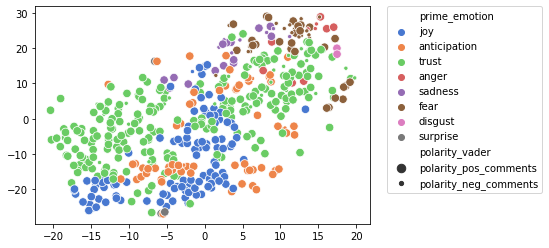

In [51]:
#plt.figure(figsize=(16,10))
sns.scatterplot(
    x=xs, y=ys,
    hue='prime_emotion',
    palette=sns.color_palette("muted", 8),
    data=doc_topic_nmf_rich_life,
    legend='full',
    #markers='polarity_plutchik',
    size='polarity_vader',
    alpha=1
    #joint_kws={"color":colors, "marker":markers}
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [52]:
doc_topic_nmf_rich_Automation = doc_topic_nmf_rich[doc_topic_nmf_rich['prime_topic'] == 'Automation']

In [53]:
tsne_features_Automation = tsne.fit_transform(doc_topic_nmf_rich_Automation.loc[:, ['trust', 'fear', 'sadness', 'anger', 
                                                                'surprise', 'disgust', 'joy', 
                                                                'anticipation']])

In [54]:
xs = tsne_features_Automation[:, 0]
ys = tsne_features_Automation[:, 1]

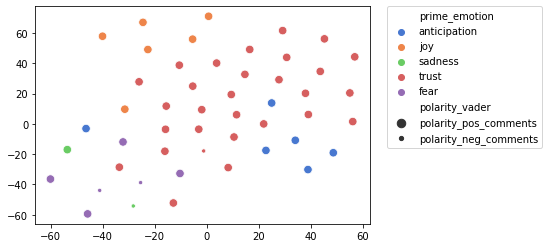

In [57]:
#plt.figure(figsize=(16,10))
sns.scatterplot(
    x=xs, y=ys,
    hue='prime_emotion',
    palette=sns.color_palette("muted", 5),
    data=doc_topic_nmf_rich_Automation,
    legend='full',
    #markers='polarity_plutchik',
    size='polarity_vader',
    alpha=1
    #joint_kws={"color":colors, "marker":markers}
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [58]:
#doc_topic[0]

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


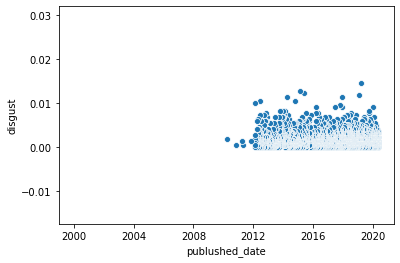

In [59]:
sns.scatterplot(x=doc_topic_nmf_rich['publushed_date'], y = doc_topic_nmf_rich['disgust']);


In [282]:
len(doc_topic)

2416

In [626]:
df.head(8)

,video_id,transcript,polarity_neg_transcript,polarity_pos_transcript,polarity_neu_transcript,polarity_compound_transcript,tags,title,publushed_date,comments_count,...,fear,negative,sadness,anger,surprise,positive,disgust,joy,anticipation,year
0,YgAuFqEs6yk,remember watch father raise pistol plead gu...,0.133,0.330,0.537,0.9996,"[Family, Parenting, Communication, Children, R...","How to co-parent as allies, not adversaries | ...",2020-05-14 14:40:00,109,...,0.003192,0.003648,0.002736,0.001824,0.004560,0.019608,0.001368,0.010032,0.008664,2020
1,bNmRr-BYnxA,think give half humanity ' spend week...,0.194,0.267,0.539,0.9980,"[climate change, environment, global issues, c...",How to shift your mindset and choose your futu...,2020-05-13 14:22:51,205,...,0.004560,0.006840,0.002280,0.003648,0.002280,0.021888,0.002280,0.004560,0.008664,2020
2,FVUkKKc3Vvk,work trading floor ' m pretty new graduate ...,0.111,0.306,0.583,0.9993,"[Life, Society, Immigration, Humanity, Self, P...",What's missing from the American immigrant nar...,2020-05-12 18:06:31,234,...,0.001368,0.001824,0.001824,0.000912,0.001824,0.005928,0.000000,0.002280,0.005016,2020
3,8bj0GR34XWc,worry pandemic pretty life play absolut...,0.135,0.166,0.699,0.9492,"[global issues, science, collaboration, virus,...",A global pandemic calls for global solutions |...,2020-05-11 15:52:37,236,...,0.002736,0.004560,0.002736,0.002736,0.001824,0.006840,0.002280,0.002736,0.002280,2020
4,eaCrsBtiYA4,public policy wonk investigate datum point ...,0.200,0.164,0.636,-0.9904,[],Racism has a cost for everyone | Heather C. Mc...,2020-05-08 18:44:35,542,...,0.000912,0.001824,0.001368,0.000912,0.002280,0.008208,0.000456,0.003192,0.003192,2020
5,OMDVTZ-ycaY,friend call week ago news drop cell phone...,0.063,0.182,0.754,0.9967,"[Humanity, Technology, Curiosity, Science, Exp...","How to spark your curiosity, scientifically | ...",2020-05-07 16:16:18,139,...,0.002736,0.003648,0.001368,0.001368,0.001824,0.007296,0.001368,0.002736,0.005016,2020
6,ppjXgm4t9ko,live Utah place know have awe inspire nat...,0.066,0.210,0.724,0.9966,"[Molecular Biology, CRISPR, Biology, Animation...","The wonders of the molecular world, animated |...",2020-05-06 17:14:06,107,...,0.001368,0.003192,0.000912,0.001368,0.000000,0.005016,0.000456,0.000000,0.000912,2020
7,wGGmzeCT8gU,' m pretty sure ' m room point find l...,0.063,0.128,0.808,0.9930,"[Planets, Space, Chemistry, Exploration, Disco...",The galactic recipe for a living planet | Kari...,2020-05-05 15:40:49,124,...,0.001368,0.001824,0.000456,0.000000,0.000456,0.006840,0.000456,0.001368,0.003192,2020


In [637]:
df['Year'] = df.publushed_date.map(lambda x: str(x.strftime('%Y')))
df['Year']

0       2020
1       2020
2       2020
3       2020
4       2020
        ... 
2070    2011
2168    2011
2178    2011
2270    2010
2416    2010
Name: Year, Length: 1978, dtype: object

In [139]:
len(doc_topic)

1978

In [628]:
df.rename(columns={'video_id':'Video ID', 'title':'Title', 'year':'Published', 'polarity_pos_comments':'Positive Comments Score'}, inplace=True )

In [639]:
with open('df.pkl', 'wb') as picklefile:
    pickle.dump(df, picklefile)

In [643]:
'https://www.youtube.com/watch?v=' + str(df['Video ID'][0])

'https://www.youtube.com/watch?v=YgAuFqEs6yk'

In [148]:
doc_topic_nmf.shape


(1978, 11)

In [189]:
doc_topic_nmf.head(8)

,Progress with technology,Phylosophy of life,Healthcare and desease treatment,International Politics,Planet sustainability,Gender,Urbanistics,Younger generation education,Neuroscience,Automation,prime_topic
video_id,,,,,,,,,,,
YgAuFqEs6yk,0.00000,0.13334,0.00000,0.00000,0.00339,0.00000,0.00000,0.05201,0.00000,0.00000,Phylosophy of life
bNmRr-BYnxA,0.00000,0.07854,0.07133,0.00351,0.03256,0.00000,0.00966,0.00000,0.00824,0.00391,Phylosophy of life
FVUkKKc3Vvk,0.00000,0.08498,0.02693,0.00000,0.00475,0.00000,0.00157,0.08811,0.00000,0.00237,Younger generation education
8bj0GR34XWc,0.02038,0.01942,0.03861,0.08282,0.00180,0.00000,0.00000,0.00000,0.00409,0.00000,International Politics
eaCrsBtiYA4,0.00000,0.03339,0.10380,0.00560,0.00000,0.01509,0.02807,0.03165,0.00000,0.00213,Healthcare and desease treatment
OMDVTZ-ycaY,0.09579,0.01261,0.00000,0.01316,0.00350,0.00000,0.00000,0.01600,0.03258,0.00000,Progress with technology
ppjXgm4t9ko,0.04149,0.00000,0.00000,0.08893,0.02821,0.00000,0.00343,0.00000,0.03181,0.00428,International Politics
wGGmzeCT8gU,0.00000,0.00000,0.00000,0.00000,0.15003,0.00000,0.00000,0.00000,0.00000,0.00000,Planet sustainability


In [66]:
with open('doc_topic_nmf.pkl', 'wb') as picklefile:
    pickle.dump(doc_topic_nmf, picklefile)

,Progress with technology,Phylosophy of life,Healthcare and desease treatment,International Politics,Planet sustainability,Gender,Urbanistics,Younger generation education,Neuroscience,Automation,prime_topic
video_id,,,,,,,,,,,
YgAuFqEs6yk,0.00000,0.13330,0.00000,0.00000,0.00341,0.00000,0.00000,0.05197,0.00000,0.00000,Phylosophy of life
bNmRr-BYnxA,0.00000,0.07851,0.07139,0.00351,0.03270,0.00000,0.00969,0.00000,0.00823,0.00397,Phylosophy of life
FVUkKKc3Vvk,0.00000,0.08495,0.02695,0.00000,0.00477,0.00000,0.00157,0.08803,0.00000,0.00241,Younger generation education
8bj0GR34XWc,0.02039,0.01942,0.03864,0.08277,0.00181,0.00000,0.00000,0.00000,0.00408,0.00000,International Politics
eaCrsBtiYA4,0.00000,0.03338,0.10388,0.00560,0.00000,0.01511,0.02814,0.03162,0.00000,0.00216,Healthcare and desease treatment
...,...,...,...,...,...,...,...,...,...,...,...
ooUqOwh-2LE,0.03916,0.06822,0.00000,0.00000,0.00000,0.00525,0.05583,0.02203,0.00000,0.00000,Phylosophy of life
SFW0TEFKCxk,0.03467,0.00000,0.00000,0.06080,0.06564,0.00000,0.01166,0.00134,0.00189,0.00023,Planet sustainability
yqc9zX04DXs,0.04623,0.01114,0.00845,0.00000,0.13062,0.00000,0.00000,0.00402,0.01934,0.00001,Planet sustainability


In [70]:
with open('doc_topic.pkl', 'wb') as picklefile:
    pickle.dump(doc_topic, picklefile)

# Recommender System

In [586]:
nmf_model

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=10, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [587]:
with open('nmf_model.pkl', 'wb') as picklefile:
    pickle.dump(nmf_model, picklefile)

In [588]:
with open('vectorizer_TF_IDF.pkl', 'wb') as picklefile:
    pickle.dump(vectorizer_TF_IDF, picklefile)

In [589]:
t = ["gender inequality is so disappoining i want to create bettwe world"]

In [590]:
#list(eval('["' + t + '"]'))

In [591]:
vt = vectorizer_TF_IDF.transform(t)

In [592]:
tt = nmf_model.transform(vt)

In [593]:
pairwise_distances(tt,doc_topic,metric='cosine').argsort()

array([[ 255,   57, 1113, ..., 1172, 1497,  193]])

In [594]:
doc_topic_nmf.iloc[255, :]

Technology               0.00371
Philosophy of Life             0
Global Economy           0.03223
Healthcare               0.00635
Planet Sustainability          0
Gender                    0.1066
Urbanistics              0.01109
Education                0.00353
Neuroscience             0.00445
Automation                     0
Topic                     Gender
Name: n0urFzhWTZ4, dtype: object

In [595]:
link = 'L375-rWJVmU'

In [596]:
index = df[df.video_id == link].index.values.tolist()

In [597]:
dist_order = pairwise_distances(doc_topic[index].reshape(1, -1),doc_topic,metric='cosine').argsort()

In [600]:
dist_order = pairwise_distances(doc_topic[0].reshape(1, -1),doc_topic,metric='cosine').argsort()

In [601]:
from itertools import chain
#dist_order.tolist()
sorted_ind = list(chain(*dist_order.tolist()))


In [602]:
rec = df.reindex(columns=['video_id', 'title', 'publushed_date'])

rec

,video_id,title,publushed_date
0,YgAuFqEs6yk,"How to co-parent as allies, not adversaries | ...",2020-05-14 14:40:00
1,bNmRr-BYnxA,How to shift your mindset and choose your futu...,2020-05-13 14:22:51
2,FVUkKKc3Vvk,What's missing from the American immigrant nar...,2020-05-12 18:06:31
3,8bj0GR34XWc,A global pandemic calls for global solutions |...,2020-05-11 15:52:37
4,eaCrsBtiYA4,Racism has a cost for everyone | Heather C. Mc...,2020-05-08 18:44:35
...,...,...,...
2070,ooUqOwh-2LE,The shared experience of absurdity | Charlie Todd,2011-11-11 16:50:21
2168,SFW0TEFKCxk,Angela Belcher: Using nature to grow batteries,2011-04-27 17:22:30
2178,yqc9zX04DXs,The history of our world in 18 minutes | David...,2011-04-11 14:42:40
2270,796LfXwzIUk,Joseph Nye on global power shifts,2010-10-27 13:31:51


In [603]:
df = df.loc[sorted_ind[:10], :]
df

,video_id,transcript,polarity_neg_transcript,polarity_pos_transcript,polarity_neu_transcript,polarity_compound_transcript,tags,title,publushed_date,comments_count,...,trust,fear,negative,sadness,anger,surprise,positive,disgust,joy,anticipation
0,YgAuFqEs6yk,remember watch father raise pistol plead gu...,0.133,0.330,0.537,0.9996,"[Family, Parenting, Communication, Children, R...","How to co-parent as allies, not adversaries | ...",2020-05-14 14:40:00,109,...,0.007296,0.003192,0.003648,0.002736,0.001824,0.004560,0.019608,0.001368,0.010032,0.008664
295,UCKfvxnljYY,today read change life limit change read ...,0.160,0.227,0.613,0.9968,"[education, community, personal growth, writin...",The healing power of reading | Michelle Kuo,2019-07-09 14:13:15,237,...,0.003192,0.002280,0.004104,0.002736,0.002280,0.000456,0.005472,0.001368,0.002736,0.002280
1416,OAK1UIb-Fio,play call Sell Buy Date Bridge Tunnel Bro...,0.082,0.273,0.645,0.9998,"[Sarah Jones (TV Actor), humor, future, sex, p...","Sarah Jones: One woman, five characters, and a...",2015-06-09 19:22:26,183,...,0.001824,0.002280,0.001824,0.001368,0.002280,0.000912,0.005016,0.001824,0.003192,0.002280
995,I1cGiNnJZgU,wonder live place rule sound pretty cool ...,0.211,0.183,0.606,-0.9890,"[Community, Disaster relief, Ebola, Health, Me...",Why civilians suffer more once a war is over |...,2017-04-13 15:13:00,78,...,0.004560,0.010032,0.012312,0.005472,0.004104,0.002280,0.009120,0.001824,0.002280,0.006384
448,oQ7vlPpUHN8,end flight remind mom ' m self teach cellis...,0.000,0.336,0.664,0.9831,"[Music, Cello, Performance Art, Performance]",How my mom inspired my approach to the cello |...,2018-12-13 22:00:19,94,...,0.001824,0.001824,0.001824,0.002280,0.001368,0.000912,0.004560,0.001824,0.002736,0.001368
226,HzAtOyw6ACw,long time ago live selfish stunning garden ...,0.130,0.125,0.745,-0.8696,"[Books, Creativity, Writing, Literature, Langu...",What reading slowly taught me about writing | ...,2019-10-08 15:09:42,210,...,0.008208,0.000912,0.001824,0.002280,0.001824,0.003648,0.014592,0.000456,0.006384,0.005472
851,ZL-6MeYBeUs,recently read young generation worker B...,0.236,0.149,0.615,-0.9959,"[Asia, United States, China, Compassion, Fear,...",What I learned as a prisoner in North Korea | ...,2017-10-20 15:25:28,2059,...,0.004560,0.005928,0.008208,0.005016,0.005472,0.001824,0.006384,0.003648,0.002736,0.004104
830,Uq1idqpX9-A,picture big sweaty tattoo cowboy hat chap r...,0.075,0.263,0.662,0.9994,"[Business, Humor, Creativity, Identity]",A pro wrestler's guide to confidence | Mike Ki...,2017-11-13 19:06:18,90,...,0.003192,0.000000,0.000456,0.000456,0.000000,0.001368,0.003648,0.000000,0.002736,0.001824
652,U4gR_cd6xOc,word matter heal kill limit eighth grade te...,0.291,0.142,0.567,-0.9971,"[Africa, humanity, society, family, refugees]",War and what comes after | Clemantine Wamariya,2018-05-15 15:07:48,155,...,0.011400,0.010944,0.017328,0.009120,0.009120,0.002736,0.018696,0.006384,0.006840,0.007296
686,5QTjSH1KGlY,grow secular middle class 1950s mean watch ...,0.082,0.215,0.703,0.9922,"[culture, future, communication, aging, person...",A rite of passage for late life | Bob Stein,2018-04-13 16:52:01,60,...,0.006840,0.001368,0.004104,0.001368,0.001368,0.002280,0.008208,0.000456,0.003192,0.002280


In [604]:
recommendation = df.loc[sorted_ind, ['video_id', 
                    'title', 
                    'publushed_date', 
                    'polarity_pos_comments'
                   ]].sort_values('polarity_pos_comments', 
                                  ascending=False).head(10).sort_values('publushed_date', 
                                                          ascending=False)

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [605]:
print('Give a chance to these videos: ')
print(recommendation.loc[:,['video_id', 'title', 'publushed_date']])

Give a chance to these videos: 
         video_id                                              title  \
0     YgAuFqEs6yk  How to co-parent as allies, not adversaries | ...   
226   HzAtOyw6ACw  What reading slowly taught me about writing | ...   
295   UCKfvxnljYY        The healing power of reading | Michelle Kuo   
448   oQ7vlPpUHN8  How my mom inspired my approach to the cello |...   
652   U4gR_cd6xOc     War and what comes after | Clemantine Wamariya   
686   5QTjSH1KGlY        A rite of passage for late life | Bob Stein   
830   Uq1idqpX9-A  A pro wrestler's guide to confidence | Mike Ki...   
851   ZL-6MeYBeUs  What I learned as a prisoner in North Korea | ...   
995   I1cGiNnJZgU  Why civilians suffer more once a war is over |...   
1416  OAK1UIb-Fio  Sarah Jones: One woman, five characters, and a...   

          publushed_date  
0    2020-05-14 14:40:00  
226  2019-10-08 15:09:42  
295  2019-07-09 14:13:15  
448  2018-12-13 22:00:19  
652  2018-05-15 15:07:48  
686  2018-04-

In [606]:
doc_topic[0]

array([0.        , 0.13316736, 0.        , 0.        , 0.00340318,
       0.        , 0.        , 0.05191446, 0.        , 0.        ])

In [607]:
doc_topic[295]

array([0.        , 0.13801393, 0.        , 0.        , 0.00463581,
       0.        , 0.        , 0.07456434, 0.        , 0.        ])

In [608]:
df

,video_id,transcript,polarity_neg_transcript,polarity_pos_transcript,polarity_neu_transcript,polarity_compound_transcript,tags,title,publushed_date,comments_count,...,trust,fear,negative,sadness,anger,surprise,positive,disgust,joy,anticipation
0,YgAuFqEs6yk,remember watch father raise pistol plead gu...,0.133,0.330,0.537,0.9996,"[Family, Parenting, Communication, Children, R...","How to co-parent as allies, not adversaries | ...",2020-05-14 14:40:00,109,...,0.007296,0.003192,0.003648,0.002736,0.001824,0.004560,0.019608,0.001368,0.010032,0.008664
295,UCKfvxnljYY,today read change life limit change read ...,0.160,0.227,0.613,0.9968,"[education, community, personal growth, writin...",The healing power of reading | Michelle Kuo,2019-07-09 14:13:15,237,...,0.003192,0.002280,0.004104,0.002736,0.002280,0.000456,0.005472,0.001368,0.002736,0.002280
1416,OAK1UIb-Fio,play call Sell Buy Date Bridge Tunnel Bro...,0.082,0.273,0.645,0.9998,"[Sarah Jones (TV Actor), humor, future, sex, p...","Sarah Jones: One woman, five characters, and a...",2015-06-09 19:22:26,183,...,0.001824,0.002280,0.001824,0.001368,0.002280,0.000912,0.005016,0.001824,0.003192,0.002280
995,I1cGiNnJZgU,wonder live place rule sound pretty cool ...,0.211,0.183,0.606,-0.9890,"[Community, Disaster relief, Ebola, Health, Me...",Why civilians suffer more once a war is over |...,2017-04-13 15:13:00,78,...,0.004560,0.010032,0.012312,0.005472,0.004104,0.002280,0.009120,0.001824,0.002280,0.006384
448,oQ7vlPpUHN8,end flight remind mom ' m self teach cellis...,0.000,0.336,0.664,0.9831,"[Music, Cello, Performance Art, Performance]",How my mom inspired my approach to the cello |...,2018-12-13 22:00:19,94,...,0.001824,0.001824,0.001824,0.002280,0.001368,0.000912,0.004560,0.001824,0.002736,0.001368
226,HzAtOyw6ACw,long time ago live selfish stunning garden ...,0.130,0.125,0.745,-0.8696,"[Books, Creativity, Writing, Literature, Langu...",What reading slowly taught me about writing | ...,2019-10-08 15:09:42,210,...,0.008208,0.000912,0.001824,0.002280,0.001824,0.003648,0.014592,0.000456,0.006384,0.005472
851,ZL-6MeYBeUs,recently read young generation worker B...,0.236,0.149,0.615,-0.9959,"[Asia, United States, China, Compassion, Fear,...",What I learned as a prisoner in North Korea | ...,2017-10-20 15:25:28,2059,...,0.004560,0.005928,0.008208,0.005016,0.005472,0.001824,0.006384,0.003648,0.002736,0.004104
830,Uq1idqpX9-A,picture big sweaty tattoo cowboy hat chap r...,0.075,0.263,0.662,0.9994,"[Business, Humor, Creativity, Identity]",A pro wrestler's guide to confidence | Mike Ki...,2017-11-13 19:06:18,90,...,0.003192,0.000000,0.000456,0.000456,0.000000,0.001368,0.003648,0.000000,0.002736,0.001824
652,U4gR_cd6xOc,word matter heal kill limit eighth grade te...,0.291,0.142,0.567,-0.9971,"[Africa, humanity, society, family, refugees]",War and what comes after | Clemantine Wamariya,2018-05-15 15:07:48,155,...,0.011400,0.010944,0.017328,0.009120,0.009120,0.002736,0.018696,0.006384,0.006840,0.007296
686,5QTjSH1KGlY,grow secular middle class 1950s mean watch ...,0.082,0.215,0.703,0.9922,"[culture, future, communication, aging, person...",A rite of passage for late life | Bob Stein,2018-04-13 16:52:01,60,...,0.006840,0.001368,0.004104,0.001368,0.001368,0.002280,0.008208,0.000456,0.003192,0.002280


In [609]:
df.to_dict()

{'video_id': {0: 'YgAuFqEs6yk',
  295: 'UCKfvxnljYY',
  1416: 'OAK1UIb-Fio',
  995: 'I1cGiNnJZgU',
  448: 'oQ7vlPpUHN8',
  226: 'HzAtOyw6ACw',
  851: 'ZL-6MeYBeUs',
  830: 'Uq1idqpX9-A',
  652: 'U4gR_cd6xOc',
  686: '5QTjSH1KGlY'},
 'transcript': {0: "   remember watch father raise pistol plead gun ignore bolt door follow close outside fire single shot remember moment frame frame remember feel numb remember feel bullet miss family way parent relationship impact know love -PRON- story different year later meet fall madly love connection undeniable hand pick think forever struggle issue parent nearly year call quit sake ooh young understand go old mommy daddy gon na live house anymore breakup hit hard decide let broken heart good sake ooh struggle initially try navigate new space co parent ask raise beautiful boy wonder promise power spite failure couple answer simple choose fear fear fear unknown choose love choose love mean see father mean see father misstep partner mean put sake time 

# debugging flask

In [610]:
t = 'i love technology and gender '
t = list(eval('["' + t + '"]'))
vt = vectorizer_TF_IDF.transform(t)
tt = nmf_model.transform(vt)
dist_order = pairwise_distances(tt,doc_topic,metric='cosine').argsort()
sorted_ind = list(chain(*dist_order.tolist()))

with open('/Users/elena/Desktop/Metis/Project_4_Ted/Project-4-Ted/df.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)
#df = df.dropna()
df = df.reindex(columns=['video_id', 'title', 'publushed_date'])
df = df.reindex(index=sorted_ind).head(5)
#df = df.loc[sorted_ind, :]
#recommendation = df.loc[sorted_ind, :].sort_values('polarity_pos_comments',
                              #ascending=False).head(10).sort_values('publushed_date',
                                                      #ascending=False)
df

,video_id,title,publushed_date
1008,NaN,NaN,2017-03-24 15:32:48
356,NaN,NaN,2019-04-09 14:48:41
73,NaN,NaN,2020-03-09 18:26:50
50,NaN,NaN,2020-03-30 19:58:06
1371,NaN,NaN,2015-07-17 22:06:37


In [134]:
dict_ = df.to_dict()

In [135]:
with open('dict_.pkl', 'wb') as picklefile:
    pickle.dump(dict_, picklefile)

In [139]:
df_toy = df.head()
df_toy.to_dict()

{'video_id': {0: 'YgAuFqEs6yk',
  1: 'bNmRr-BYnxA',
  2: 'FVUkKKc3Vvk',
  3: '8bj0GR34XWc',
  4: 'eaCrsBtiYA4'},
 'transcript': {0: "   remember watch father raise pistol plead gun ignore bolt door follow close outside fire single shot remember moment frame frame remember feel numb remember feel bullet miss family way parent relationship impact know love -PRON- story different year later meet fall madly love connection undeniable hand pick think forever struggle issue parent nearly year call quit sake ooh young understand go old mommy daddy gon na live house anymore breakup hit hard decide let broken heart good sake ooh struggle initially try navigate new space co parent ask raise beautiful boy wonder promise power spite failure couple answer simple choose fear fear fear unknown choose love choose love mean see father mean see father misstep partner mean put sake time mean parent go forth try work thing brother brother sake appreciate effort wish see hear know sake story ku parent get 